# Stock Price Prediction With LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy as dc
import torch.optim as optim
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

### Preparing Data

In [2]:
df = pd.read_csv('mag7.csv')
df.tail()

,Date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
2510,2024-11-18,228.020004,201.699997,175.300003,554.400024,415.760010,140.149994,338.739990
2511,2024-11-19,228.279999,204.610001,178.119995,561.090027,417.790009,147.009995,346.000000
2512,2024-11-20,229.000000,202.880005,175.979996,565.520020,415.489990,145.889999,342.029999
2513,2024-11-21,228.520004,198.380005,167.630005,563.090027,412.869995,146.669998,339.640015
2514,2024-11-22,229.869995,197.119995,164.759995,559.140015,417.000000,141.949997,352.559998


In [3]:
df_nvda = df[['Date', 'NVDA']]
df_nvda.tail(3)

,Date,NVDA
2512,2024-11-20,145.889999
2513,2024-11-21,146.669998
2514,2024-11-22,141.949997


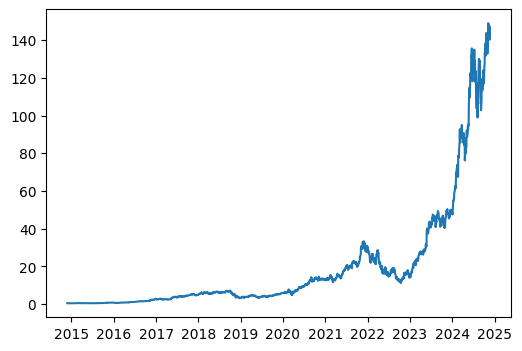

In [4]:
df_nvda['Date'] = pd.to_datetime(df_nvda['Date'])
df_nvda = df_nvda.rename(columns={'NVDA':'Close'}) 

plt.figure(figsize=(6, 4))
plt.plot(df_nvda['Date'], df_nvda['Close'])

In [5]:
def prepare_dataset(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

lockback = 7
shifted_df = prepare_dataset(df_nvda, lockback)
shifted_df.head(3)

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-12-08,0.52000,0.52675,0.52375,0.52850,0.51525,0.51450,0.52425,0.52300
2014-12-09,0.51825,0.52000,0.52675,0.52375,0.52850,0.51525,0.51450,0.52425
2014-12-10,0.50675,0.51825,0.52000,0.52675,0.52375,0.52850,0.51525,0.51450


In [6]:
shifted_df_numpy = shifted_df.to_numpy()
shifted_df_numpy

array([[  0.51999998,   0.52675003,   0.52375001, ...,   0.51450002,
          0.52424997,   0.523     ],
       [  0.51824999,   0.51999998,   0.52675003, ...,   0.51525003,
          0.51450002,   0.52424997],
       [  0.50674999,   0.51824999,   0.51999998, ...,   0.52850002,
          0.51525003,   0.51450002],
       ...,
       [145.88999939, 147.00999451, 140.1499939 , ..., 146.27000427,
        148.28999329, 145.25999451],
       [146.66999817, 145.88999939, 147.00999451, ..., 146.75999451,
        146.27000427, 148.28999329],
       [141.94999695, 146.66999817, 145.88999939, ..., 141.97999573,
        146.75999451, 146.27000427]])

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_numpy = scaler.fit_transform(shifted_df_numpy)

shifted_df_numpy

array([[-0.99944071, -0.99934974, -0.99939017, ..., -0.99951483,
        -0.99938343, -0.99940028],
       [-0.99946429, -0.99944071, -0.99934974, ..., -0.99950472,
        -0.99951483, -0.99938343],
       [-0.99961928, -0.99946429, -0.99944071, ..., -0.99932615,
        -0.99950472, -0.99951483],
       ...,
       [ 0.95970384,  0.97479796,  0.88234606, ...,  0.96482515,
         0.99204844,  0.95121329],
       [ 0.97021584,  0.95970384,  0.97479796, ...,  0.97142872,
         0.96482515,  0.99204844],
       [ 0.90660461,  0.97021584,  0.95970384, ...,  0.90700891,
         0.97142872,  0.96482515]])

In [8]:
#[all rows, first col - last]
X = shifted_df_numpy[:, 1:]
y = shifted_df_numpy[:, 0]

X.shape, y.shape

((2508, 7), (2508,))

In [9]:
#from 7 - 1 -> for lstm
X = dc(np.flip(X, axis=1))
X

array([[-0.99940028, -0.99938343, -0.99951483, ..., -0.99932615,
        -0.99939017, -0.99934974],
       [-0.99938343, -0.99951483, -0.99950472, ..., -0.99939017,
        -0.99934974, -0.99944071],
       [-0.99951483, -0.99950472, -0.99932615, ..., -0.99934974,
        -0.99944071, -0.99946429],
       ...,
       [ 0.95121329,  0.99204844,  0.96482515, ...,  0.90700891,
         0.88234606,  0.97479796],
       [ 0.99204844,  0.96482515,  0.97142872, ...,  0.88234606,
         0.97479796,  0.95970384],
       [ 0.96482515,  0.97142872,  0.90700891, ...,  0.97479796,
         0.95970384,  0.97021584]])

In [10]:
split_index = int(len(X) * 0.80)
split_index

2006

In [11]:
X_train = X[: split_index]
X_test = X[split_index :]

y_train = y[: split_index]
y_test = y[split_index :]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2006, 7), (502, 7), (2006,), (502,))

In [12]:
#for lstm dim

X_train = X_train.reshape((-1, lockback, 1))
X_test = X_test.reshape((-1, lockback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2006, 7, 1), (502, 7, 1), (2006, 1), (502, 1))

In [13]:
X_train = torch.tensor( X_train).float()
X_test = torch.tensor(X_test ).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test ).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2006, 7, 1]),
 torch.Size([502, 7, 1]),
 torch.Size([2006, 1]),
 torch.Size([502, 1]))

In [14]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

In [16]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Basic LSTM

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    

In [18]:
input_size = 1
hidden_size = 4
num_layers = 1
model = LSTMModel(input_size, hidden_size, num_layers)

model

LSTMModel(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
learning_rate = 0.001
num_epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train LSTM model
print("Training LSTM model...")
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Training LSTM model...


In [20]:
# Evaluate LSTM model
model.eval()
lstm_predictions, lstm_actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

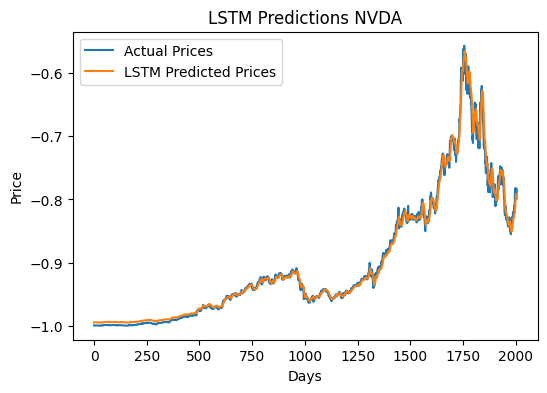

In [21]:
with torch.no_grad():
    predicted = model(X_train).numpy()

# Plot LSTM results
plt.figure(figsize=(6, 4))
plt.plot(y_train, label='Actual Prices')
plt.plot(predicted, label='LSTM Predicted Prices')
plt.title(f"LSTM Predictions NVDA")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

###  LSTM Model with Dropout

In [22]:
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=self.dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) 
        return out

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModelWithDropout(input_size=1, hidden_size=50, num_layers=2, dropout_rate=0.3).to(device)

# Hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization (weight decay)
criterion = nn.MSELoss()

# Early stopping mechanism
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait before stopping
patience_counter = 0

# Training loop with early stopping
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validation step to check for early stopping
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pth')  # Save the model with best validation loss
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss: {best_val_loss:.4f}")
            break

# Load the best model
model.load_state_dict(torch.load('best_lstm_model.pth'))

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()


Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 117.07it/s]


Epoch 1/50, Training Loss: 0.1551, Validation Loss: 0.7352


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 129.39it/s]


Epoch 2/50, Training Loss: 0.0086, Validation Loss: 0.6776


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 134.91it/s]


Epoch 3/50, Training Loss: 0.0076, Validation Loss: 0.5726


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 132.43it/s]


Epoch 4/50, Training Loss: 0.0054, Validation Loss: 0.3872


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 120.04it/s]


Epoch 5/50, Training Loss: 0.0015, Validation Loss: 0.2989


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 124.23it/s]


Epoch 6/50, Training Loss: 0.0011, Validation Loss: 0.2936


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 121.75it/s]


Epoch 7/50, Training Loss: 0.0009, Validation Loss: 0.2814


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 116.95it/s]


Epoch 8/50, Training Loss: 0.0009, Validation Loss: 0.2772


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 129.22it/s]


Epoch 9/50, Training Loss: 0.0009, Validation Loss: 0.2719


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 124.79it/s]


Epoch 10/50, Training Loss: 0.0007, Validation Loss: 0.2576


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 134.55it/s]


Epoch 11/50, Training Loss: 0.0007, Validation Loss: 0.2544


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 136.73it/s]


Epoch 12/50, Training Loss: 0.0006, Validation Loss: 0.2475


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 121.66it/s]


Epoch 13/50, Training Loss: 0.0006, Validation Loss: 0.2424


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 133.32it/s]


Epoch 14/50, Training Loss: 0.0005, Validation Loss: 0.2350


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 134.08it/s]


Epoch 15/50, Training Loss: 0.0005, Validation Loss: 0.2286


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 124.79it/s]


Epoch 16/50, Training Loss: 0.0005, Validation Loss: 0.2230


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 139.36it/s]


Epoch 17/50, Training Loss: 0.0004, Validation Loss: 0.2221


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 137.02it/s]


Epoch 18/50, Training Loss: 0.0004, Validation Loss: 0.2203


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 136.51it/s]


Epoch 19/50, Training Loss: 0.0004, Validation Loss: 0.2189


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 131.34it/s]


Epoch 20/50, Training Loss: 0.0003, Validation Loss: 0.2156


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 111.40it/s]


Epoch 21/50, Training Loss: 0.0004, Validation Loss: 0.2192


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 117.97it/s]


Epoch 22/50, Training Loss: 0.0003, Validation Loss: 0.2201


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 139.50it/s]


Epoch 23/50, Training Loss: 0.0003, Validation Loss: 0.2186


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 141.52it/s]


Epoch 24/50, Training Loss: 0.0003, Validation Loss: 0.2176


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 138.25it/s]


Epoch 25/50, Training Loss: 0.0003, Validation Loss: 0.2177


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 138.28it/s]


Epoch 26/50, Training Loss: 0.0004, Validation Loss: 0.2161


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 124.23it/s]


Epoch 27/50, Training Loss: 0.0003, Validation Loss: 0.2227


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 120.58it/s]


Epoch 28/50, Training Loss: 0.0003, Validation Loss: 0.2166


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 130.44it/s]


Epoch 29/50, Training Loss: 0.0003, Validation Loss: 0.2139


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 129.40it/s]


Epoch 30/50, Training Loss: 0.0003, Validation Loss: 0.2179


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 128.64it/s]


Epoch 31/50, Training Loss: 0.0003, Validation Loss: 0.2143


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 129.83it/s]


Epoch 32/50, Training Loss: 0.0003, Validation Loss: 0.2138


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 124.54it/s]


Epoch 33/50, Training Loss: 0.0002, Validation Loss: 0.2176


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 128.02it/s]


Epoch 34/50, Training Loss: 0.0003, Validation Loss: 0.2097


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 134.03it/s]


Epoch 35/50, Training Loss: 0.0003, Validation Loss: 0.2090


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 135.41it/s]


Epoch 36/50, Training Loss: 0.0002, Validation Loss: 0.2054


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 128.05it/s]


Epoch 37/50, Training Loss: 0.0002, Validation Loss: 0.2097


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 129.85it/s]


Epoch 38/50, Training Loss: 0.0002, Validation Loss: 0.2173


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 120.71it/s]


Epoch 39/50, Training Loss: 0.0002, Validation Loss: 0.2167


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 137.03it/s]


Epoch 40/50, Training Loss: 0.0002, Validation Loss: 0.2084


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 131.65it/s]


Epoch 41/50, Training Loss: 0.0002, Validation Loss: 0.2088


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 115.95it/s]


Epoch 42/50, Training Loss: 0.0002, Validation Loss: 0.2079


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 126.53it/s]


Epoch 43/50, Training Loss: 0.0002, Validation Loss: 0.2015


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 118.00it/s]


Epoch 44/50, Training Loss: 0.0002, Validation Loss: 0.2008


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 126.58it/s]


Epoch 45/50, Training Loss: 0.0002, Validation Loss: 0.2031


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 127.14it/s]


Epoch 46/50, Training Loss: 0.0003, Validation Loss: 0.1922


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 135.60it/s]


Epoch 47/50, Training Loss: 0.0002, Validation Loss: 0.1958


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 127.97it/s]


Epoch 48/50, Training Loss: 0.0002, Validation Loss: 0.1985


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 121.98it/s]


Epoch 49/50, Training Loss: 0.0002, Validation Loss: 0.1907


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 122.35it/s]

Epoch 50/50, Training Loss: 0.0002, Validation Loss: 0.1971


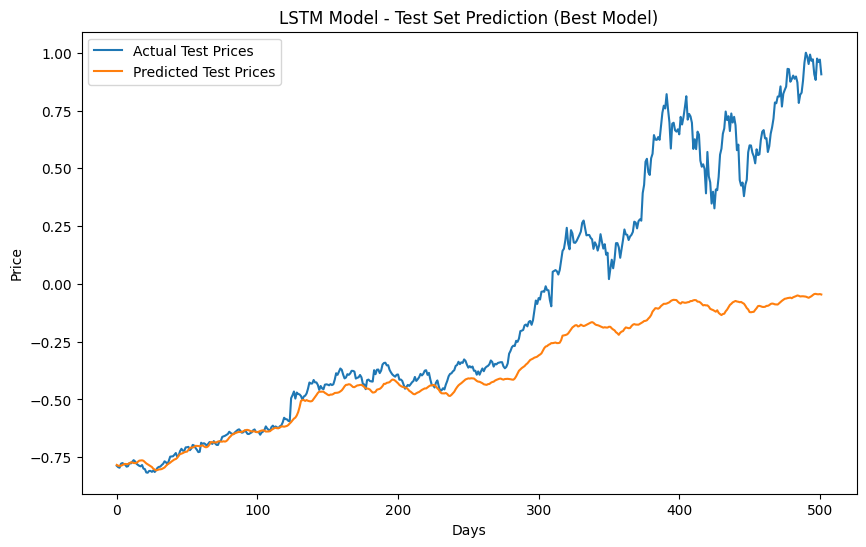

In [24]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.cpu().numpy(), label='Actual Test Prices')
plt.plot(test_predictions, label='Predicted Test Prices')
plt.title('LSTM Model - Test Set Prediction (Best Model)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()